1. Calcular correlações das features extraídas pelo Word2Vec
2. Se observadas correlações altas, aplicar PCA
3. Fazer uma Ridge Regression
4. Fazer uma Árvore de Regressão (R)

# Apoio

In [105]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from scipy import stats
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import train_test_split

O dataset utilizado será o com 50 dimensões pois foi o que obteve os melhores resultados na Regressão Linear

In [83]:
# Leitura do dataset com 50 dimensões
df = pd.read_pickle('../data/final/enem_data_embeddings_50.pkl')
df.head()

,numero_questao,gabarito,NU_PARAM_A,nu_param_B,NU_PARAM_C,ANO,enunciado,alternativas,gabarito_texto,distratores,enunciado_limpo,alternativas_limpo,gabarito_texto_limpo,distratores_limpo,enunciado_embeddings_word2vec,gabarito_embeddings_word2vec
0,1,C,3.43894,0.97831,0.10855,2017,"No império africano do Mali, no século XIV, To...",A: isolamento geográﬁco do Saara ocidental; B...,posição relativa nas redes de circulação,isolamento geográﬁco do Saara ocidental; explo...,africano além astronomia centro cidade comérci...,A: isolamento ocidental saara; B: exploração i...,circulação posição redes relativa,competição econômica exploração intensiva isol...,"[0.09772969, 0.013166125, -0.032748703, 0.0580...","[-0.04434625, 0.2105245, -0.18144351, 0.030336..."
1,2,D,3.00837,0.49169,0.13877,2017,Após a Declaração Universal dos Direitos Human...,A: ataque feito pelos japoneses à base milita...,execução de judeus e eslavos presos em guetos ...,ataque feito pelos japoneses à base militar am...,aberrações acontecimentos após assumida branco...,A: americana ataque base feito harbor japonese...,campos concentração eslavos execução guetos ju...,americana americanas ataque atômicas base bomb...,"[-0.018823402, 0.07832528, -0.016192827, 0.027...","[0.21008351, 0.5248949, 0.03625112, 0.01772637..."
2,3,D,0.60432,3.25992,0.08798,2017,"A moralidade, Bentham exortava, não é uma ques...",A: fundamentação cientíﬁca de viés positivist...,racionalidade de caráter pragmático,fundamentação cientíﬁca de viés positivista; c...,abstratas afetados agradar ação bentham condut...,A: fundamentação positivista viés; B: convençã...,caráter pragmático racionalidade,comportamental convenção fundamentação inclina...,"[-0.013062097, 0.038470805, -0.020605344, 0.05...","[0.16413634, -0.035050992, 0.08454134, 0.23227..."
3,4,E,1.85031,0.57925,0.11344,2017,Fala-se muito nos dias de hoje em direitos do ...,A: modernização da educação escolar; B: atuali...,universalização do princípio da igualdade civil,modernização da educação escolar; atualização ...,apresenta assembleia bases bem cidadão concepç...,A: educação escolar modernização; B: atualizaç...,civil igualdade princípio universalização,aristocráticos atualização conhecimento costum...,"[-0.042833664, -0.01434522, -0.002431296, 0.01...","[0.102909006, 0.06116425, -0.13846825, 0.33034..."
4,5,C,2.46290,0.76307,0.17672,2017,Na Constituição da República Federativa do Bra...,A: etnia e miscigenação racial; B: sociedade...,espaço e sobrevivência cultural,etnia e miscigenação racial; sociedade e igual...,aplicação artigo bens brasil competindo consta...,A: etnia miscigenação racial; B: igualdade jur...,cultural espaço sobrevivência,ambiental bem econômica educação etnia igualda...,"[0.010493249, 0.11095436, 0.017243173, 0.05319...","[0.267512, -0.081234336, 0.08019033, 0.1294613..."


In [84]:
df_final = df[['enunciado_embeddings_word2vec', 'nu_param_B']]
df_final.rename(columns={'nu_param_B': 'y', 'enunciado_embeddings_word2vec':'X'}, inplace=True)
df_final.head()

/tmp/ipykernel_8377/480942482.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final.rename(columns={'nu_param_B': 'y', 'enunciado_embeddings_word2vec':'X'}, inplace=True)


,X,y
0,"[0.09772969, 0.013166125, -0.032748703, 0.0580...",0.97831
1,"[-0.018823402, 0.07832528, -0.016192827, 0.027...",0.49169
2,"[-0.013062097, 0.038470805, -0.020605344, 0.05...",3.25992
3,"[-0.042833664, -0.01434522, -0.002431296, 0.01...",0.57925
4,"[0.010493249, 0.11095436, 0.017243173, 0.05319...",0.76307


In [85]:
# Removendo observações Nan
df_final = df_final[df_final['y'].notna()].reset_index()

# Análise de correlação

In [86]:
# Explodindo a coluna X em várias colunas
df_features = pd.DataFrame(df_final['X'].tolist(), index=df_final.index)

df_features.columns = [f'X{i+1}' for i in range(df_features.shape[1])]

df_features.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X41,X42,X43,X44,X45,X46,X47,X48,X49,X50
0,0.097730,0.013166,-0.032749,0.058064,0.066659,0.055518,0.005533,-0.010803,0.124288,-0.010112,...,-0.058407,0.149049,-0.103425,0.085180,0.109060,0.018974,0.037986,0.010234,-0.070827,-0.104570
1,-0.018823,0.078325,-0.016193,0.027615,0.080563,-0.001443,-0.011481,-0.011694,0.046921,-0.053186,...,0.060602,0.106786,0.061356,0.139279,0.123225,-0.019229,0.167333,0.101951,-0.028866,-0.109328
2,-0.013062,0.038471,-0.020605,0.051806,0.062729,-0.029429,0.076300,0.081863,0.074962,0.029681,...,0.061806,0.264843,0.080967,0.118467,0.042564,-0.042368,0.108510,0.100451,-0.141360,-0.054252
3,-0.042834,-0.014345,-0.002431,0.015723,0.100305,0.023464,0.047759,0.088246,0.083725,-0.059424,...,-0.084707,0.104256,0.096123,0.056716,0.125574,-0.014302,0.038790,0.018908,-0.013034,-0.059200
4,0.010493,0.110954,0.017243,0.053193,0.005365,-0.082108,0.063029,-0.078666,-0.008422,0.028746,...,0.009678,0.141793,0.088591,0.131339,0.022100,0.004114,0.075874,0.088452,-0.058793,-0.005872


<Axes: >

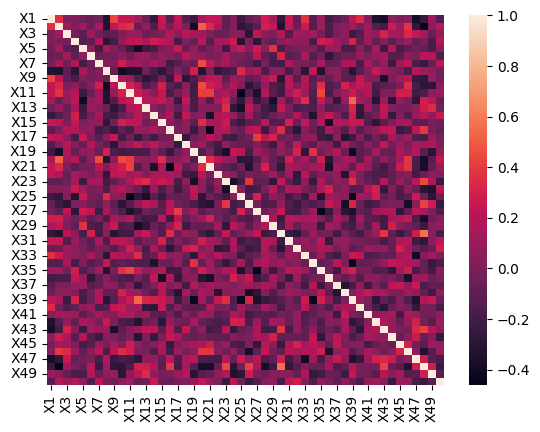

In [16]:
sns.heatmap(df_features.corr())

<Axes: >

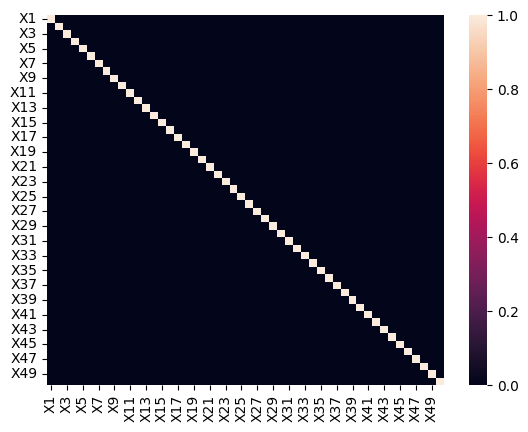

In [22]:
sns.heatmap(df_features.corr() > 0.7)

Como nenhuma correlação alta ou baixa foi encontrada, dar-se-á seguimento das análises com as 50 variáveis originais.

# Ridge Regression

In [89]:
def cross_validate_ridge_rmse(X, y, alphas, cv=5):
    kf = KFold(n_splits=cv, shuffle=True, random_state=42)
    alpha_rmse = {}

    for alpha in alphas:
        rmse_list = []

        for train_index, val_index in kf.split(X):
            # print(train_index)
            # print(val_index)
            X_train, X_val = X.iloc[train_index], X.iloc[val_index]
            # print('hi')
            # print(list(train_index))
            y_train, y_val = y.iloc[train_index], y.iloc[val_index]

            # Adiciona o intercepto
            X_train_const = sm.add_constant(X_train)
            X_val_const = sm.add_constant(X_val)

            # Ajusta o modelo com regularização L2 (Ridge)
            model = sm.OLS(y_train, X_train_const)
            result = model.fit_regularized(alpha=alpha, L1_wt=0.0)

            # Predições
            y_pred = np.dot(X_val_const, result.params)

            # Calcula o RMSE
            rmse = np.sqrt(mean_squared_error(y_val, y_pred))
            rmse_list.append(rmse)

        # Média dos RMSEs para o alpha atual
        alpha_rmse[alpha] = np.mean(rmse_list)

    return alpha_rmse


In [99]:
# Separando os dados
X = df_features
y = df_final['y']


# Aplicando Transformações
add_list = [(y.min() * (-1)) + 1] * len(y)
y = y + add_list

# Aplicando Boxcox
y, _ = stats.boxcox(y)
y = pd.Series(y)

In [100]:
# Adiciona o intercepto
X = sm.add_constant(X)

# Definindo uma lista de valores de alpha para testar
alphas = np.logspace(-4, 4, 50)

# Executando a validação cruzada
alpha_rmse = cross_validate_ridge_rmse(X, y, alphas, cv=5)

# Encontrando o alpha com o menor RMSE médio
best_alpha = min(alpha_rmse, key=alpha_rmse.get)
print(f"Melhor alpha: {best_alpha}")
print(f"RMSE correspondente: {alpha_rmse[best_alpha]}")


Melhor alpha: 0.009102981779915217
RMSE correspondente: 0.47799005456600874


In [106]:
# Separando em conjunto de treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# Adiciona o intercepto
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

# Ajusta o modelo final com o melhor alpha encontrado
final_model = sm.OLS(y_train, X_train)
final_result = final_model.fit_regularized(alpha=best_alpha, L1_wt=0.0)

# Exibe os coeficientes
print(final_result.params)

[ 1.25707121e+00 -1.42655354e-01 -2.59478755e-01 -2.01702013e-01
  2.72996336e-05 -1.55147305e-01 -5.69474744e-02 -1.03580406e-01
  1.29743705e-01 -1.17004413e-02 -1.68058242e-02  5.72844879e-02
  2.87853775e-01  1.99690063e-01  2.51081465e-01 -2.38477482e-02
  7.74330956e-03 -2.60615428e-01  1.23398226e-01 -9.09202577e-02
  6.63372338e-02 -2.05602199e-01 -4.05279205e-02  7.59542660e-02
 -5.87839865e-02 -1.69145969e-01  7.18930083e-02 -4.60227875e-01
 -2.46449484e-01 -8.09568826e-02  1.50454202e-01  2.32715888e-01
  8.01975031e-02 -8.35857490e-02 -2.44431650e-01  2.99124339e-01
 -8.90382304e-02  7.33598206e-02  1.62731303e-01  2.83645583e-01
  2.17306309e-01 -1.37642233e-01  4.05099611e-01 -9.34614134e-02
  9.37897104e-02  3.80020959e-01 -7.53986819e-02  4.76793981e-02
  2.51992589e-01 -1.33532414e-02 -1.51477503e-01]


In [108]:
# Para o conjunto de treino
y_train_pred = final_result.predict(X_train)

# Para o conjunto de teste
y_test_pred = final_result.predict(X_test)

# Calculando os RMSE
rmse_train = root_mean_squared_error(y_train, y_train_pred)
rmse_test = root_mean_squared_error(y_test, y_test_pred)

print(f'RMSE no conjunto de Treino: {rmse_train}')
print(f'RMSE no conjunto de Teste: {rmse_test}')

RMSE no conjunto de Treino: 0.44086865153528965
RMSE no conjunto de Teste: 0.4953540837547408


In [111]:
y

0      1.384018
1      1.034893
2      2.781651
3      1.099655
4      1.232730
         ...   
262    0.996316
263    0.847299
264    0.744515
265    0.721424
266    0.481873
Length: 267, dtype: float64

In [118]:
pd.concat([df_features, y], axis=1).rename(columns={0:'y'}).to_csv('enem_data_embeddings_50_exploded.csv', index=False)

# Árvore de Regressão

In [ ]:
# Célula necessária para rodar R no notebook -> dependência necessária: rpy2
%load_ext rpy2.ipython

/home/alesouza/.cache/pypoetry/virtualenvs/projeto-enem-YISx0mk8-py3.11/lib/python3.11/site-packages/rpy2/rinterface/__init__.py:1185: UserWarning: Environment variable "PWD" redefined by R and overriding existing variable. Current: "/mnt/c/Users/aleso/AppData/Local/Programs/Microsoft VS Code", R: "/home/alesouza/USP/9_semestre/pcd-iii/projeto_enem/enem-embbedings-social-questions/notebooks"
  warnings.warn(
/home/alesouza/.cache/pypoetry/virtualenvs/projeto-enem-YISx0mk8-py3.11/lib/python3.11/site-packages/rpy2/rinterface/__init__.py:1185: UserWarning: Environment variable "LD_LIBRARY_PATH" redefined by R and overriding existing variable. Current: "/usr/lib/R/lib:/usr/lib/x86_64-linux-gnu:/usr/lib/jvm/default-java/lib/server", R: "/usr/lib/R/lib:/usr/lib/x86_64-linux-gnu:/usr/lib/jvm/default-java/lib/server:/usr/lib/R/lib:/usr/lib/x86_64-linux-gnu:/usr/lib/jvm/default-java/lib/server"
  warnings.warn(
/home/alesouza/.cache/pypoetry/virtualenvs/projeto-enem-YISx0mk8-py3.11/lib/python3.

In [161]:
%%R 

# Lendo o dataset
df = read.csv('../data/final/enem_data_embeddings_50_exploded.csv')
head(df)

           X1          X2           X3         X4          X5           X6
1  0.09772969  0.01316613 -0.032748703 0.05806443 0.066659436  0.055518378
2 -0.01882340  0.07832528 -0.016192827 0.02761456 0.080562994 -0.001443487
3 -0.01306210  0.03847080 -0.020605344 0.05180575 0.062729254 -0.029428812
4 -0.04283366 -0.01434522 -0.002431296 0.01572310 0.100305110  0.023463674
5  0.01049325  0.11095436  0.017243173 0.05319270 0.005365026 -0.082108210
6  0.04537390  0.08738215  0.032880560 0.02180354 0.056987580 -0.018176196
            X7           X8           X9         X10          X11           X12
1  0.005533437 -0.010802587  0.124287784 -0.01011208  0.018697912 -0.0003421853
2 -0.011481154 -0.011693998  0.046920873 -0.05318647 -0.021356557  0.0619864130
3  0.076300030  0.081862830  0.074962385  0.02968106  0.029135782  0.1245678400
4  0.047758590  0.088245920  0.083724600 -0.05942424 -0.052274883  0.0051423777
5  0.063029320 -0.078666046 -0.008422477  0.02874596  0.004533599  0.035029

In [143]:
%%R

# Importando pacote necessário
library(tree)

# Inicializando uma seed
set.seed(42)

In [144]:
%%R

# Porcentagem do conjunto de teste
alpha = 0.7
inTrain = sample(1:nrow(df), alpha * nrow(df))

# Dividindo os conjuntos
train.set = df[inTrain,]
test.set = df[-inTrain,]

In [146]:
%%R

# Treinando o modelo com o conjunto de treino
df.model = tree(y ~ ., data = train.set)
df.model

node), split, n, deviance, yval
      * denotes terminal node



  1) root 186 46.23000 1.4400  
    2) X49 < -0.158059 21  3.05100 1.0120  
      4) X41 < 0.0499021 10  0.55110 1.2580 *
      5) X41 > 0.0499021 11  1.35000 0.7891  
       10) X9 < 0.0652442 5  0.40400 0.4973 *
       11) X9 > 0.0652442 6  0.16540 1.0320 *
    3) X49 > -0.158059 165 38.85000 1.4940  
      6) X17 < -0.0228147 96 24.88000 1.6130  
       12) X42 < 0.23317 86 19.85000 1.5550  
         24) X45 < 0.119825 46 11.05000 1.7060  
           48) X2 < 0.0511796 20  2.94000 1.9660  
             96) X38 < -0.0967825 6  0.69300 2.3380 *
             97) X38 > -0.0967825 14  1.05700 1.8060  
              194) X32 < -0.055316 7  0.07767 2.0220 *
              195) X32 > -0.055316 7  0.32730 1.5900 *
           49) X2 > 0.0511796 26  5.71800 1.5060  
             98) X23 < -0.125038 5  1.12000 0.9593 *
             99) X23 > -0.125038 21  2.74800 1.6360  
              198) X34 < -0.16229 9  1.11700 1.8870 *
              199) X34 > -0.16229 12  0.64370 1.4480 *
         25) X45

In [147]:
%%R 

summary(df.model)


Regression tree:
tree(formula = y ~ ., data = train.set)
Variables actually used in tree construction:
 [1] "X49" "X41" "X9"  "X17" "X42" "X45" "X2"  "X38" "X32" "X23" "X34" "X18"
[13] "X43" "X37" "X24" "X21" "X39" "X14" "X10" "X46"
Number of terminal nodes:  24 
Residual mean deviance:  0.07725 = 12.51 / 162 
Distribution of residuals:
     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
-0.855000 -0.155700  0.002073  0.000000  0.164700  0.587200 


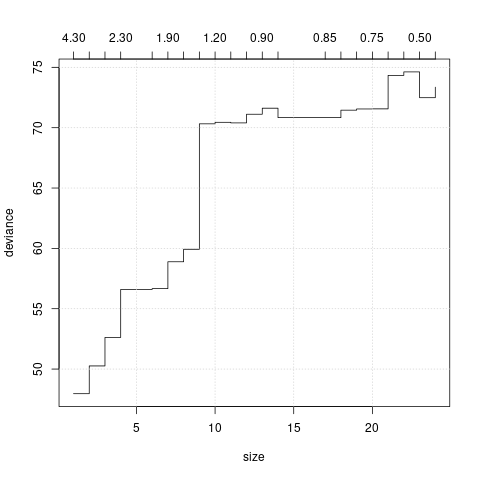

In [149]:
%%R 

# Utilizando validação cruzada para encontrar a melhor árvore
cv.model = cv.tree(df.model)
plot(cv.model); grid()

In [150]:
%%R
best.size = cv.model$size[which(cv.model$dev == min(cv.model$dev))]
best.size

[1] 1


In [157]:
%%R 
cv.model.pruned = prune.tree(df.model, best=2)
summary(cv.model.pruned)


Regression tree:
snip.tree(tree = df.model, nodes = 2:3)
Variables actually used in tree construction:
[1] "X49"
Number of terminal nodes:  2 
Residual mean deviance:  0.2277 = 41.9 / 184 
Distribution of residuals:
     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
-1.390000 -0.293900  0.005155  0.000000  0.291500  1.428000 


**Métricas da Árvore resultante da validação cruzada**

In [158]:
%%R
library(Metrics)

# Previsões no conjunto de treinamento
pred_train <- predict(cv.model.pruned, newdata = train.set)

# Previsões no conjunto de teste
pred_test <- predict(cv.model.pruned, newdata = test.set)

# Calcular o RMSE para os conjuntos de treinamento e teste
rmse_train <- rmse(train.set$y, pred_train)
rmse_test <- rmse(test.set$y, pred_test)

# Exibir os resultados
cat("RMSE no conjunto de treinamento:", round(rmse_train, 4), "\n")
cat("RMSE no conjunto de teste:", round(rmse_test, 4), "\n")

RMSE no conjunto de treinamento: 0.4746 
RMSE no conjunto de teste: 0.455 


**Métricas da Árvore calculada inicialmente**

In [160]:
%%R
# Previsões no conjunto de treinamento
pred_train <- predict(df.model, newdata = train.set)

# Previsões no conjunto de teste
pred_test <- predict(df.model, newdata = test.set)

# Calcular o RMSE para os conjuntos de treinamento e teste
rmse_train <- rmse(train.set$y, pred_train)
rmse_test <- rmse(test.set$y, pred_test)

# Exibir os resultados
cat("RMSE no conjunto de treinamento:", round(rmse_train, 4), "\n")
cat("RMSE no conjunto de teste:", round(rmse_test, 4), "\n")

RMSE no conjunto de treinamento: 0.2594 
RMSE no conjunto de teste: 0.5772 
